Julia Pawluś, Kamil Sarzyniak, Piotr Stawarski 


Przewidywanie przyszłych wartości ceny zamknięcia (Close) z wykorzystaniem metody Fuzzy Time Series.

In [1]:
#pip install -U pyFTS
import pyFTS
import pandas as pd
import numpy as np
np.int = int

In [2]:
from pyFTS.data import Bitcoin

In [3]:
df = Bitcoin.get_dataframe()

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,AVG
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0,0.049510
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,5,0.070152
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,49,0.084235
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,20,0.077902
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,42,0.074875


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.set_index('Date', inplace=True)


In [7]:
print(df.head())

               Open     High      Low    Close  Volume       AVG
Date                                                            
2010-07-16  0.04951  0.04951  0.04951  0.04951       0  0.049510
2010-07-17  0.04951  0.08585  0.05941  0.08584       5  0.070152
2010-07-18  0.08584  0.09307  0.07723  0.08080      49  0.084235
2010-07-19  0.08080  0.08181  0.07426  0.07474      20  0.077902
2010-07-20  0.07474  0.07921  0.06634  0.07921      42  0.074875


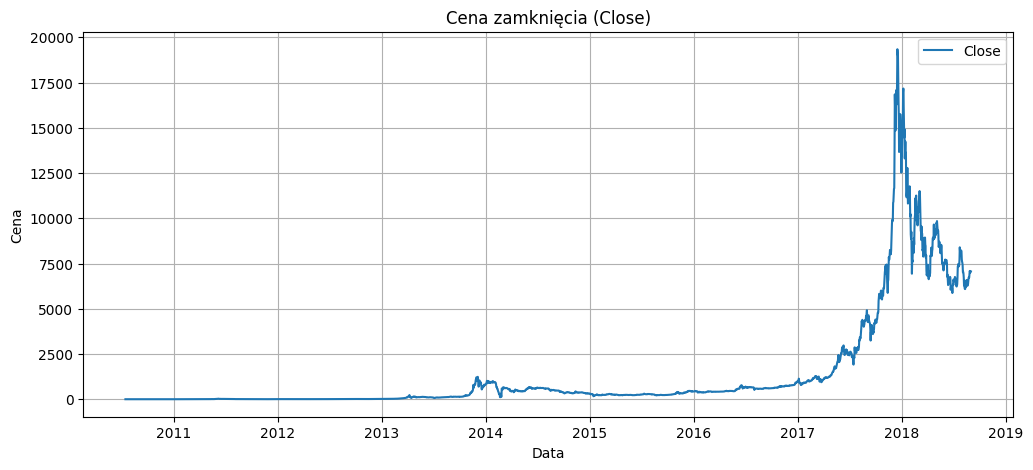

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close')
plt.title("Cena zamknięcia (Close)")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
series = df['Close'].dropna().values

min_val = min(series)
max_val = max(series)

print(f"Zakres danych: min = {min_val:.2f}, max = {max_val:.2f}")

Zakres danych: min = 0.05, max = 19345.49


In [10]:
from pyFTS.partitioners import Grid

# 10 rozmytych zbiorów 
partitioner = Grid.GridPartitioner(data=series, npart=10)


In [11]:
# Zobaczmy etykiety i zakresy zbiorów
for s in partitioner.sets:
    print(s)


A0
A1
A2
A3
A4
A5
A6
A7
A8
A9


In [12]:
from pyFTS.partitioners import Grid
partitioner = Grid.GridPartitioner(data=series, npart=10)


In [13]:

# Zamieniamy zbiory rozmyte na listę posortowaną po nazwach (np. A0, A1, ...)
sorted_sets = sorted(partitioner.sets.values(), key=lambda x: x.name)

relational_groups = []

for i, s in enumerate(sorted_sets):
    left = max(0, i - 1)
    right = min(len(sorted_sets) - 1, i + 1)
    neighbors = [sorted_sets[j].name for j in range(left, right + 1)]
    relational_groups.append({'Zbiór': s.name, 'Sąsiedztwo': ', '.join(neighbors)})

df_groups = pd.DataFrame(relational_groups)
print(df_groups)


  Zbiór  Sąsiedztwo
0    A0      A0, A1
1    A1  A0, A1, A2
2    A2  A1, A2, A3
3    A3  A2, A3, A4
4    A4  A3, A4, A5
5    A5  A4, A5, A6
6    A6  A5, A6, A7
7    A7  A6, A7, A8
8    A8  A7, A8, A9
9    A9      A8, A9


c:\Users\KamilSarzyniak\anaconda3\envs\AI_DL_ML\lib\site-packages\pyFTS\partitioners\partitioner.py:238: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(ticks)


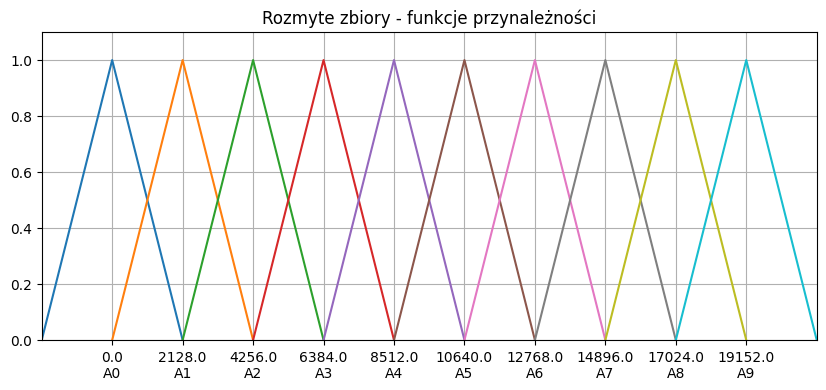

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))  
partitioner.plot(ax)                   
plt.title("Rozmyte zbiory - funkcje przynależności")
plt.grid(True)
plt.show()



In [15]:
from pyFTS.models import chen

# Tworzenie modelu Fuzzy Time Series typu Chen
model_chen = chen.ConventionalFTS(partitioner=partitioner)

# Trenowanie modelu
model_chen.fit(series)


In [16]:
# Predykcja na podstawie serii danych
predicted_chen = model_chen.predict(series)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(series[1:], predicted_chen[1:])
rmse = mean_squared_error(series[1:], predicted_chen[1:])**0.5

print(f"MAE (Chen): {mae:.4f}")
print(f"RMSE (Chen): {rmse:.4f}")


MAE (Chen): 790.2869
RMSE (Chen): 850.5441


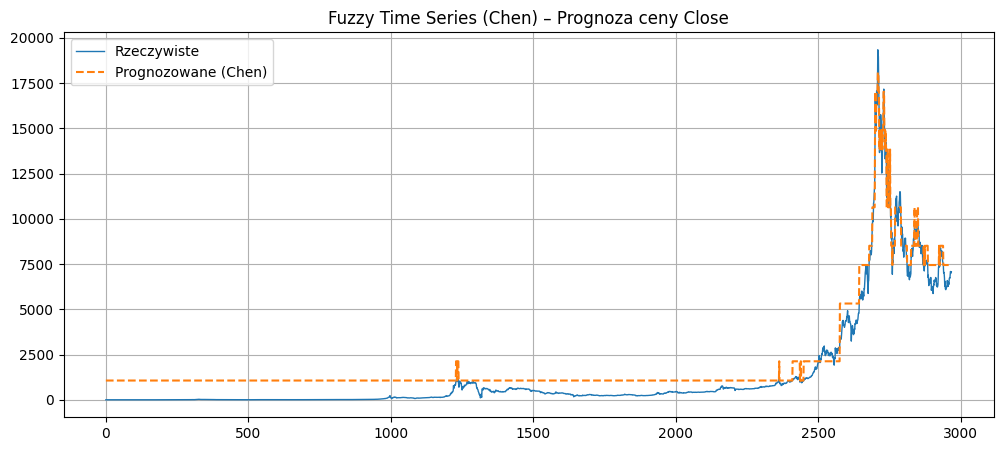

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(series, label='Rzeczywiste', linewidth=1)
plt.plot(predicted_chen, label='Prognozowane (Chen)', linestyle='--')
plt.title("Fuzzy Time Series (Chen) – Prognoza ceny Close")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from deap import base, creator, tools, algorithms

def evaluate(individual):
    npart = int(individual[0])
    if npart < 3 or npart > 50:  # limit partition size
        return 1e6,

    try:
        partitioner = Grid.GridPartitioner(data=series, npart=npart)
        model = chen.ConventionalFTS(partitioner=partitioner)
        model.fit(series)
        predicted = model.predict(series)
        rmse = mean_squared_error(series[1:], predicted[1:])**0.5
    except Exception as e:
        return 1e6,

    return rmse,


In [20]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()


In [21]:
toolbox.register("attr_int", np.random.randint, 5, 30)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=1.0, low=3, up=50, indpb=1.0)
toolbox.register("select", tools.selTournament, tournsize=3)


In [22]:
# Run the GA
np.random.seed(42)
population = toolbox.population(n=20)
hof = tools.HallOfFame(1)

algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, halloffame=hof, verbose=True)

# Get best number of partitions
best_npart = int(hof[0][0])
print(f"Najlepsza liczba zbiorów rozmytych: {best_npart}")


gen	nevals
0  	20    
1  	9     
2  	10    
3  	7     
4  	13    
5  	10    
6  	14    
7  	8     
8  	10    
9  	7     
10 	12    
11 	9     
12 	12    
13 	11    
14 	12    
15 	17    
Najlepsza liczba zbiorów rozmytych: 47


In [23]:
partitioner = Grid.GridPartitioner(data=series, npart=best_npart)
model_best = chen.ConventionalFTS(partitioner=partitioner)
model_best.fit(series)
predicted_best = model_best.predict(series)


In [24]:
mae = mean_absolute_error(series[1:], predicted_best[1:])
rmse = mean_squared_error(series[1:], predicted_best[1:])**0.5

print(f"MAE (Optymalizowany Chen): {mae:.4f}")
print(f"RMSE (Optymalizowany Chen): {rmse:.4f}")


MAE (Optymalizowany Chen): 161.4028
RMSE (Optymalizowany Chen): 186.9711


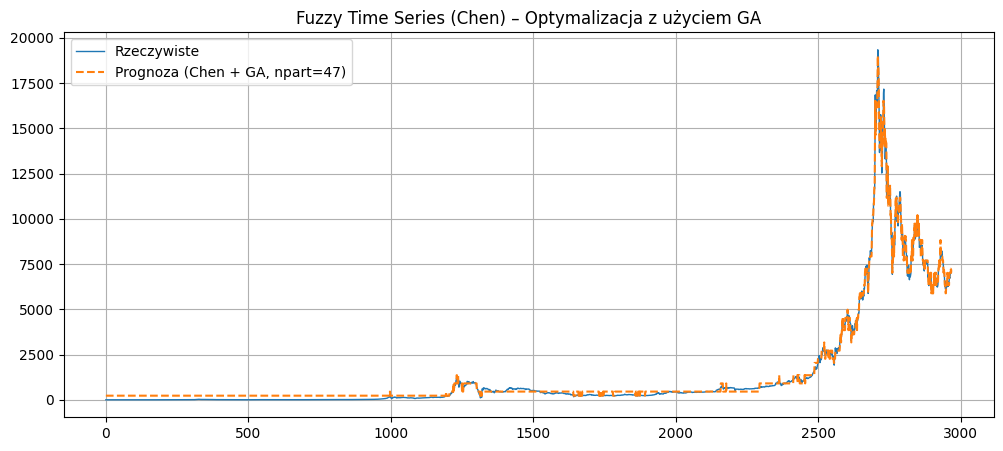

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(series, label='Rzeczywiste', linewidth=1)
plt.plot(predicted_best, label=f'Prognoza (Chen + GA, npart={best_npart})', linestyle='--')
plt.title("Fuzzy Time Series (Chen) – Optymalizacja z użyciem GA")
plt.legend()
plt.grid(True)
plt.show()
